In [1]:
import pandas as pd, numpy as np
import importlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.figsize'] = (12,8)

In [2]:
import sys
sys.path.append("../../")
# Importing my helper module
from tennis_predictor import clean_data

In [3]:
data = pd.read_csv("../../independant_observations.csv", index_col=0, low_memory=False)
data.Date = data.Date.astype(np.datetime64)
data = data.sort_values(by="Date")
data.head()

,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1_Name,P1_Rank,...,P2__3M__Won_International,P2__3M__Won_International Gold,P2__3M__Won_International Series,P2__3M__Won_Masters,P2__3M__Won_Masters 1000,P2__3M__Won_Masters Cup,P2__3M__Won_Quarterfinals,P2__3M__Won_Round Robin,P2__3M__Won_Semifinals,P2__3M__Won_The Final
14518,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Saulnier C.,53.0,...,0.003663,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
14551,Chennai,TATA Open,2005-01-03,International,Outdoor,Hard,1st Round,3,Tipsarevic J.,117.0,...,0.023891,0.000443,0.000000,0.000294,0.0,0.0,0.004647,0.0,0.000244,0.000027
14550,Chennai,TATA Open,2005-01-03,International,Outdoor,Hard,1st Round,3,Gambill J.M.,95.0,...,0.002536,0.003877,0.000000,0.000000,0.0,0.0,0.000038,0.0,0.000000,0.000000
14549,Chennai,TATA Open,2005-01-03,International,Outdoor,Hard,1st Round,3,Schuettler R.,42.0,...,0.009684,0.002246,0.002009,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
14554,Chennai,TATA Open,2005-01-03,International,Outdoor,Hard,1st Round,3,Heuberger I.,124.0,...,0.000736,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000


# 1/ Exploratory Data Analysis Summary

## 1.A The baseline
The baseline could be to predict that the better ranked player will win the tennis game. This yields an accuracy of **65.68%**

## 1.B Adding derived features

** As a reminder the features that are provided upfront by the dataset are relatively limited: **

In [4]:
data.loc[:, [c for c in data.columns if "__" not in c]].head()

,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1_Name,P1_Rank,...,P2_Name,P2_Rank,P2_1,P2_2,P2_3,P2_4,P2_5,P2_Sets,Player1Wins,RankDiff
14518,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Saulnier C.,53.0,...,Baccanello P.,324.0,2.0,6.0,NaN,NaN,NaN,0.0,True,-271.0
14551,Chennai,TATA Open,2005-01-03,International,Outdoor,Hard,1st Round,3,Tipsarevic J.,117.0,...,Mathieu P.H.,123.0,6.0,6.0,NaN,NaN,NaN,2.0,False,-6.0
14550,Chennai,TATA Open,2005-01-03,International,Outdoor,Hard,1st Round,3,Gambill J.M.,95.0,...,Gimelstob J.,162.0,6.0,6.0,NaN,NaN,NaN,2.0,False,-67.0
14549,Chennai,TATA Open,2005-01-03,International,Outdoor,Hard,1st Round,3,Schuettler R.,42.0,...,Patience O.,119.0,6.0,6.0,NaN,NaN,NaN,2.0,False,-77.0
14554,Chennai,TATA Open,2005-01-03,International,Outdoor,Hard,1st Round,3,Heuberger I.,124.0,...,Amritraj P.,340.0,4.0,4.0,NaN,NaN,NaN,0.0,True,-216.0


We basically have the names of the players, their ranks, and various fields about the type of game:
* The Series: "Grand Slam", "ATP500", etc.
* The type of surface, if it is indoor or outdoor
* Tournament name, location
* The Round (Final, 1st Round etc.)
I deliberately ignored the in-game statistics (eg. 6-4 6-4 6-4), as well as the various betting odds that were provided

** As part of the EDA work, I have added some derived features that basically represent that performance of both players until that point in time **

In [40]:
P1_custom_columns = [c for c in data.columns if "__" in c and "P1" in c]
P1_custom_columns[:10]

['P1__TOTAL__Played',
 'P1__TOTAL__Won',
 'P1__TOTAL__Won_1st Round',
 'P1__TOTAL__Won_2nd Round',
 'P1__TOTAL__Won_3rd Round',
 'P1__TOTAL__Won_4th Round',
 'P1__TOTAL__Won_ATP250',
 'P1__TOTAL__Won_ATP500',
 'P1__TOTAL__Won_Grand Slam',
 'P1__TOTAL__Won_International']

For each player, we have to total number of games played and won until that point in time (to be exact until just the day before), as well as how many specific types of wins they have:
* The number of 1st Round wins, the number of Final wins (win for each type of Round)
* The number of Gramd Slam wins (win for each type of ATP Series)

On top of the totals, those features are duplicated with an exponential moving average with a 3M half life

* All of those features have been **normalized** (removed mean and divided by std())
* Also I chose to only consider the rows after 2005, so that we have enough history (2000-2005) for the derived features

# 2/ Choosing what features to derive in preparation for modelling

The difficult for this problem is that most of the features used to model are custom engineered features. My first intuition was basically that:
* The more a player wins, the more likely he is to win again!
* Not all wins are worth the same, a final vs a 1st Round, a Grand Slam vs an ATP250 win

To capture those ideas I had derived the TOTAL wins as well as the 3M exponential moving average for the following reasons:
* So that I could capture both the performance of the players since the beginning of time
* And the *current dynamic* of the players, as hilighted by the graphs in the EDA

## 2.A Choosing the half-life ot the exponential moving average

I experimented with various values for the the width of the exponential moving average: 1Y, 6M, 3M, 1M etc.
**I noticed that the precision of a Logistic Regression model was converging towards 1 as the width of the exponential moving average decreased**
This was due to a mistake of mine: When predicting game happing on day D, I was using the performance of both players **until day D inclusive**, and basically relying on the very outcome I'm trying to predict...

I have corrected this by basically considering the performance of both players **until D-1** only. Reducing the width of the moving average doesn't make the precision of a Logistic Regresison converge towards 1 anymore

Using a basic cross validation technique, (looking at the precision of a basic default logistic regression) I found that 3M gives the best boost in precision so I stuck with that

# 3/ Modelling

## 3.A First look at a Logistic Regression

In [6]:
columns = [c for c in data if "__" in c]  # All the various engineered features have "__" in their names

### Let's look at the accuracy of a Logistic Regression
Accuracy is probably the better metric here, what we care about is correctly predicting the winner either P1 or P2, which is equivalent to P1 wins or loses.
There is little point, given the way I'm framing the problem to consider a pure precision or recall approach as here the situation is symmetric, P1 and P2 are assigned arbitrarily

In [7]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
X = data[columns]
Y = data.Player1Wins

lr.fit(X, Y)
training_set_accuracy = lr.score(X, Y)
training_set_accuracy

0.67807343169978473

### If we add dummies for all the other columns does it help?

In [8]:
dummies_df = pd.get_dummies(data[["Surface", "Court", "Round", "Tournament", "Series"]])
data_with_dummies = data.join(dummies_df, how="inner")
X2 = data_with_dummies[columns + list(dummies_df.columns) + ["Best of"]]

lr2 = LogisticRegression()
lr2.fit(X2, Y)
lr2.score(X2, Y)

0.68053779205789688

Hardly ..

So let's stick to the original columns, for now we beat the baseline by about 2.5%

Let's look at the various weights

### Looking at the coefficients

In [9]:
from tennis_predictor import modelling
import importlib
importlib.reload(modelling)
feature_coefs = modelling.format_feature_coefs(columns, lr.coef_[0])
feature_coefs.head()

,Coef
Feature,
P1__TOTAL__Played,-0.006627
P1__TOTAL__Won,-0.042024
P1__TOTAL__Won_1st Round,0.058805
P1__TOTAL__Won_2nd Round,0.058248
P1__TOTAL__Won_3rd Round,0.047733


Let's order the coefficients by abs value descending, as the features have been normalised, the absolute value of a feature's coefficient can be interpreted as its relative importance

In [10]:
feature_coefs = modelling.sort_feature_coefs_by_bas(feature_coefs)
feature_coefs.head(15)

,Coef
Feature,
P1__3M__Won,4.643737
P2__3M__Played,-4.452802
P2__3M__Won,-3.409523
P1__3M__Played,3.361079
P1__3M__Won_Grand Slam,1.301056
P1__3M__Won_Masters,1.254341
P1__3M__Won_2nd Round,1.167063
P1__3M__Won_Masters 1000,1.091233
P2__3M__Won_1st Round,-1.059204


A way to interpret those is that basically, the more `P1` wins over the previous 3 months the more likelye `P1` will win, the more `P2` wins over the last three months the **less** likely `P1` will win, etc.

Now if we look at the least important features:

In [11]:
feature_coefs.tail(10)

,Coef
Feature,
P2__TOTAL__Won_International Series,0.004039
P2__TOTAL__Won_International,-0.003344
P2__TOTAL__Won_2nd Round,0.003060
P1__TOTAL__Won_International,-0.002939
P2__TOTAL__Won_International Gold,-0.002284
P1__TOTAL__Won_Grand Slam,0.002081
P2__TOTAL__Won_ATP250,-0.001904
P1__TOTAL__Won_Masters,-0.001632
P1__TOTAL__Won_ATP500,-0.000777


We can basically extrapolate that `TOTAL` type of features are basically less useful than their `3M` counterpart

## 3.B Cross validation

Let's assess some **real** performance, ie the score on data the model hasn't been trained on

In [12]:
FOLDS_NB = 5
scores = []

lr3b = LogisticRegression()

from sklearn.model_selection import KFold
kf = KFold(n_splits=FOLDS_NB, shuffle=True)
for train, test in kf.split(X):
    lr3b.fit(X.iloc[train], Y.iloc[train])
    scores.append(lr3b.score(X.iloc[test], Y.iloc[test]))
print(scores, np.array(scores).mean())

[0.67966313162819714, 0.68293824079850285, 0.671970051474029, 0.68179691155825928, 0.66463890188738106] 0.676201447469


The accuracy for a 5-Fold cross validation is very close to the training set performance:

In [13]:
np.array(scores).mean() - training_set_accuracy

-0.0018719842305108259

### Time based cross validation
It'd be interesting to do a *time based* cross validation here, as in real life, new data will always be more recent
So let's train on the 80% earliest observations, and evaluate on the 20% latest:

In [14]:
cutoff = int(X.shape[0] * 0.9)
lr3b.fit(X.iloc[:cutoff], Y.iloc[:cutoff])
lr3b.score(X.iloc[cutoff:], Y.iloc[cutoff:])

0.67654398003742977

Not too bad either!
** Conclusion, we can be quite confident that used for new data, the accuracy will be preserved **

## 3.C Hyperparameter search (on a subset of the whole data, 10% ~= 3K)

In [15]:
from sklearn.model_selection import GridSearchCV
random_subset = np.random.choice(np.arange(X.shape[0]), int(X.shape[0] / 20))
params = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-3, 3, base=10, num=4),
}
gs = GridSearchCV(LogisticRegression(), params, cv=3)
gs.fit(X.iloc[random_subset], Y.iloc[random_subset])

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-03,   1.00000e-01,   1.00000e+01,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
gs.best_params_

{'C': 0.001, 'penalty': 'l1'}

In [17]:
gs.best_score_

0.65293383270911365

In [18]:
gs.param_grid

{'C': array([  1.00000000e-03,   1.00000000e-01,   1.00000000e+01,
          1.00000000e+03]), 'penalty': ['l1', 'l2']}

**Note**:
* Running GridSearchCV takes a long time on the whole dataset, so I've run it only on a subset of the whole data (with CV enabled in the GridSearch)
* There was quite a lot of variability around the best params/scores..., Ive stuck with lasso penalty and C=0.3

## 3.D Cross validation again

In [30]:
FOLDS_NB = 5
scores = []

lr3d = LogisticRegression(penalty="l1", C=0.3)

from sklearn.model_selection import KFold
kf = KFold(n_splits=FOLDS_NB, shuffle=True)
for train, test in kf.split(X):
    lr3d.fit(X.iloc[train], Y.iloc[train])
    scores.append(lr3d.score(X.iloc[test], Y.iloc[test]))

In [31]:
cross_validation_score = np.array(scores).mean()
print(scores, np.array(scores).mean())

[0.67966313162819714, 0.66827822832189643, 0.68725627827172053, 0.67696147246919358, 0.67462174387771023] 0.677356170914


In [32]:
cv_feature_coefs4d = modelling.format_feature_coefs(columns, lr4d.coef_[0])
cv_feature_coefs4d = modelling.sort_feature_coefs_by_bas(cv_feature_coefs4d)
cv_feature_coefs4d[cv_feature_coefs4d.Coef != 0].head(15)
# Let's look at the most useful features

,Coef
Feature,
P1__3M__Won,11.059759
P2__3M__Won,-7.188933
P2__3M__Played,-3.290804
P2__TOTAL__Won_Masters Cup,0.026317
P2__TOTAL__Won_Masters 1000,-0.018534
P2__TOTAL__Won_Semifinals,-0.017426
P2__TOTAL__Won_Grand Slam,-0.013695
P2__TOTAL__Won_4th Round,0.010711
P2__TOTAL__Won_Masters,-0.010315


In [33]:
# Let's look at the least useful features
cv_feature_coefs4d[cv_feature_coefs4d.Coef == 0].head()

,Coef
Feature,
P1__3M__Won_3rd Round,0.0
P1__3M__Won_ATP250,0.0
P1__3M__Won_4th Round,0.0
P1__3M__Won_Grand Slam,0.0
P1__3M__Won_2nd Round,0.0


## 3.E Does incorporating the player's ranks help??

In [34]:
lr_rank = LogisticRegression(penalty="l1", C=0.3)
lr_rank.fit(data[columns + ["P1_Rank", "P2_Rank"]], Y)
lr_rank.score(data[columns + ["P1_Rank", "P2_Rank"]], Y)

0.67760551517609258

Not really.. I guess we could say that we kind of find a model that is somewhat redundant with the ATP rankings, and marginally better (+2%)

# 4/ Looking at the most important features

In [35]:
data = data.assign(
    plot_color=np.where(data.Player1Wins, "blue", "red")
)

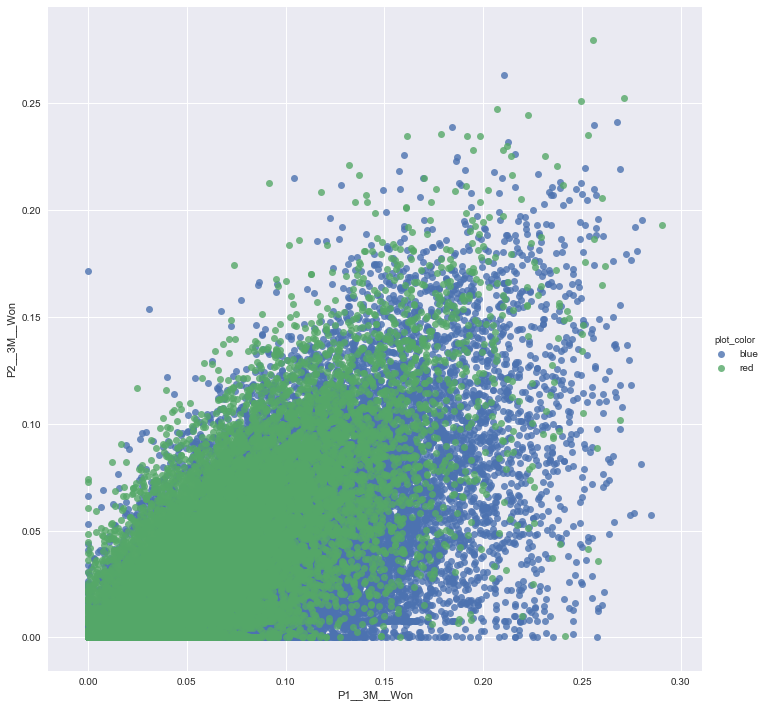

In [36]:
sns.lmplot("P1__3M__Won", "P2__3M__Won", data=data, hue="plot_color", fit_reg=False, size=10)

* One can see that the blue dots (player 1 wins) tend to be more towards the right and the bottom, which corresponds to higher P1 wins and lower P2 wins.
* Also we see that the precision is not great here (lower than 67% as we only use two features) as we can't really cleanly split the dataset in two

# 5/ Going further

## Let's try another model..
I did this project with Logistic Regression in mind but let's try random forest out of curiosity...

In [37]:
from sklearn.ensemble import RandomForestClassifier
gscv5 = GridSearchCV(RandomForestClassifier(), param_grid={"max_depth": np.arange(2, 10)})
gscv5.fit(X, Y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [38]:
gscv5.best_params_

{'max_depth': 7}

In [39]:
gscv5.best_score_

0.67114826714914055

**Very interesting** we're getting a very similar number here!!!

## Improving the performance
**More data?**:
There's many different ways one could engineer features, we could like at deriving things which are more complex than 3M rolling exponential rolling averages:
* We could try to cluster groups of player together, and then look at how "good" or "bad" a player is against a player of a given group and use that as a feature. For this clustering, in-game statistics will probably be very useful? (% first serve, served speed etc.)
* A somehow related idea would be to look at the history of games between two players
* Another idea could be to further refine the existing "Won" features by giving them more weight depending on in-game statistics such as the score for example (ie if you win 6-0 6-0 6-0 it's a more impressive win)
* We could try to derive how many days of rest you've had so far in a given tournament
* etc.

**Different models?**
I've tried Logistic Regression and Random Forests, maybe more complex models could perform better here? Neural Nets?